In [1]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
from sqlalchemy import create_engine
import os
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns


pd.set_option("display.max_rows",None)

In [2]:

load_dotenv(r"/home/bdcmartinez/Desktop/Projects/Sales-Demand-Forecasting-API/notebooks/.env")

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")


engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")


## Get the data from the database

In [3]:
df_products = pd.read_sql("SELECT * FROM products;", engine)

In [4]:
df_sales = pd.read_sql("SELECT * FROM sales;", engine)

In [5]:
df_regions = pd.read_sql("SELECT * FROM regions", engine)

In [6]:
df_sales.head()

,id,product_id,region_id,date,quantity,payment_method
0,1,28,12,2021-11-10,54.0,Cash
1,2,20,12,2021-11-10,96.0,Cash
2,3,5,12,2021-11-10,41.0,Mobile App
3,4,18,12,2021-11-10,102.0,Cash
4,5,18,12,2021-11-10,62.0,Debit Card


In [7]:
df_products.head()

,id,name,category,selling_cost,product_cost
0,1,Bread Loaf,Bakery,17.20,7.62
1,2,Croissant,Bakery,13.10,4.68
2,3,Muffin,Bakery,7.71,1.34
3,4,Bagel,Bakery,9.05,1.84
4,5,Apple Juice,Beverages,13.15,6.05


In [8]:
df_regions.head()

,id,state_code,state_name,city,latitude,longitude
0,12,GA,Georgia,Cartersville,34.16533,-84.80231
1,33,GA,Georgia,Warner Robins,32.61574,-83.62664
2,7,GA,Georgia,Belvedere Park,33.75483,-84.26742
3,5,GA,Georgia,Atlanta,33.74900,-84.38798
4,31,GA,Georgia,Union City,33.58706,-84.54243


### Join the data to then obtain insights

In [9]:
df = df_sales.merge(df_products[['id','name','category', 'selling_cost', 'product_cost']], left_on = 'product_id', right_on ='id',how='left')[["region_id",'date','quantity','payment_method','name','category', 'selling_cost', 'product_cost']]


In [10]:
df = df.merge(df_regions[['id','state_code','state_name','city']], left_on='region_id', right_on='id', how='left')[['date','quantity','payment_method','name','category','state_code','state_name','city','selling_cost','product_cost']]

In [11]:
df = df[['date', 'name', 'category','quantity', 'product_cost', 'selling_cost', 'payment_method', 'state_code',
       'state_name', 'city']]

In [12]:
df.head()

,date,name,category,quantity,product_cost,selling_cost,payment_method,state_code,state_name,city
0,2021-11-10,Banana,Produce,54.0,7.93,14.30,Cash,GA,Georgia,Cartersville
1,2021-11-10,Chicken Breast,Meat,96.0,8.01,14.29,Cash,GA,Georgia,Cartersville
2,2021-11-10,Apple Juice,Beverages,41.0,6.05,13.15,Mobile App,GA,Georgia,Cartersville
3,2021-11-10,Frozen Vegetables,Frozen Foods,102.0,8.56,16.44,Cash,GA,Georgia,Cartersville
4,2021-11-10,Frozen Vegetables,Frozen Foods,62.0,8.56,16.44,Debit Card,GA,Georgia,Cartersville


## Explore the data to gain insights

#### We check the data for outliers

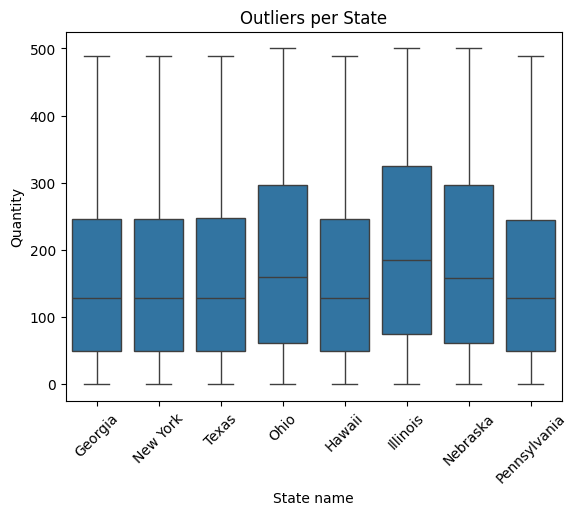

In [92]:
sns.boxplot(data=df_sales_joined, x='state_name', y='quantity')
plt.xticks(rotation=45)
plt.xlabel("State name")
plt.ylabel("Quantity")
plt.title("Outliers per State")
plt.show()


In [13]:
df.describe()


,date,quantity,product_cost,selling_cost
count,5369952,5.369952e+06,5.369952e+06,5.369952e+06
mean,2024-06-09 21:47:43.646620928,1.689094e+02,6.603762e+00,1.406573e+01
min,2021-11-10 00:00:00,-1.000000e+00,1.340000e+00,7.710000e+00
25%,2023-04-03 00:00:00,5.300000e+01,4.760000e+00,1.283000e+01
50%,2024-08-30 00:00:00,1.390000e+02,7.240000e+00,1.448000e+01
75%,2025-11-21 00:00:00,2.650000e+02,8.920000e+00,1.605000e+01
max,2025-11-21 00:00:00,5.000000e+02,9.770000e+00,1.864000e+01
std,NaN,1.330707e+02,2.568646e+00,2.884132e+00


In [14]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369952 entries, 0 to 5369951
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   name            object        
 2   category        object        
 3   quantity        float64       
 4   product_cost    float64       
 5   selling_cost    float64       
 6   payment_method  object        
 7   state_code      object        
 8   state_name      object        
 9   city            object        
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 409.7+ MB


#### How many sales by month do we have?

In [15]:
df_state_name = df.groupby('state_name')['quantity'].sum().reset_index().copy()

In [16]:
df_plot = df_state_name.sort_values(by='quantity', ascending=False)

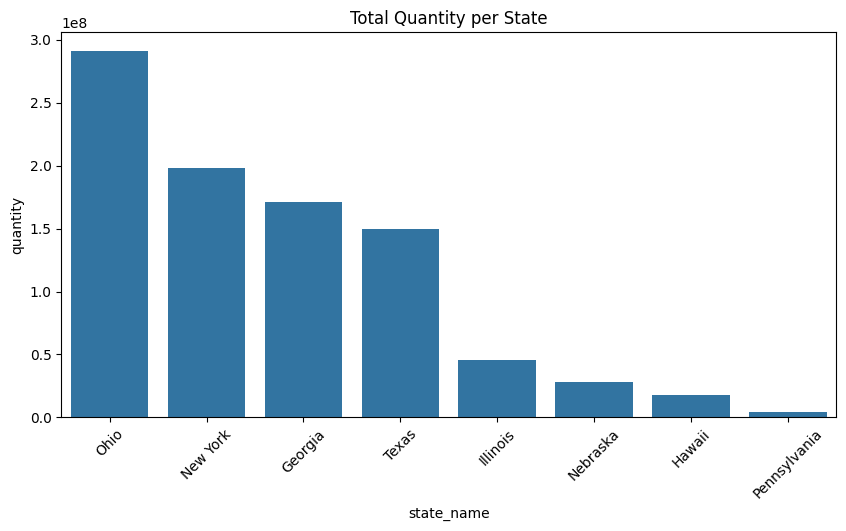

In [17]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_plot, x='state_name', y='quantity')
plt.title("Total Quantity per State")
plt.xticks(rotation=45)
plt.show()


#### Which are the citites with higher sales?

In [18]:
df_city = df.groupby('city')["quantity"].sum().reset_index().sort_values(by='quantity', ascending=False)

In [19]:
df_city = df_city[0:10]

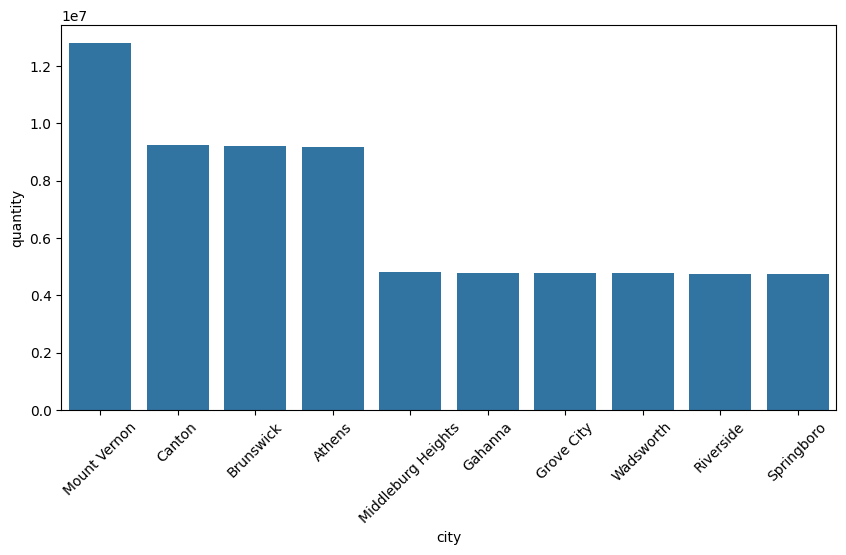

In [20]:
plt.figure(figsize = (10,5))
sns.barplot(data = df_city, x = 'city', y = 'quantity')
plt.xticks(rotation=45)
plt.show()

#### Which is the product most sold during the last 6 months?

In [21]:
df_products = df.groupby('name')['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)

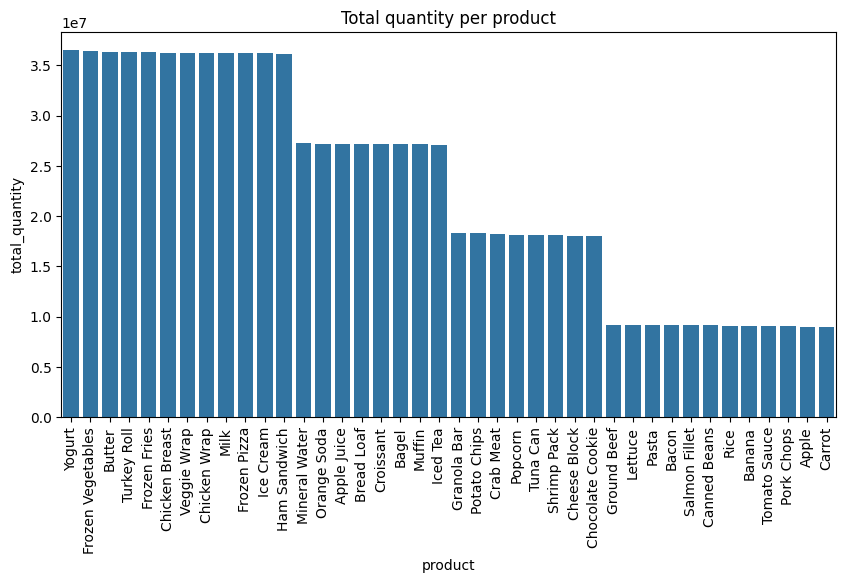

In [22]:
plt.figure(figsize = (10,5))
sns.barplot(data = df_products, x='name', y = 'quantity')
plt.xlabel('product')
plt.ylabel('total_quantity')
plt.title('Total quantity per product')
plt.xticks(rotation=90)
plt.show()

#### What are the state with a higher revenue?

In [23]:
df["revenue"]  =  df['selling_cost']*df['quantity'] - df['product_cost']*df['quantity']

In [24]:
df_state_rev = df.groupby('state_name')['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)

In [25]:
df_state_rev = df_state_rev[0:15]

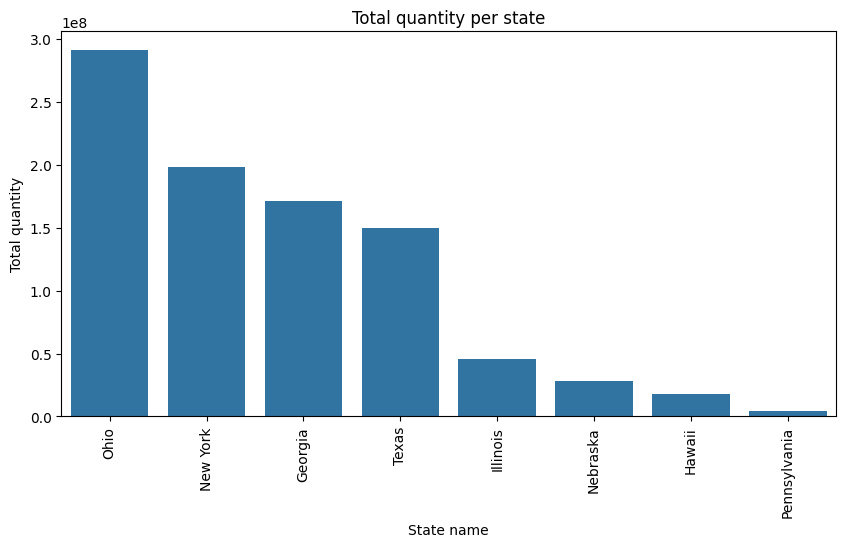

In [26]:
plt.figure(figsize = (10,5))
sns.barplot(data = df_state_rev, x = 'state_name', y = 'quantity')
plt.xlabel('State name')
plt.ylabel('Total quantity')
plt.title('Total quantity per state')
plt.xticks(rotation=90)
plt.show()

### How have been the revenue per month for the states?

In [86]:
df_month = df[df['date']<'2023-11-01'].copy()

In [87]:
df_month['month'] = df_month['date'].dt.to_period('M').dt.to_timestamp()

In [88]:
df_month_state = df_month.groupby(['month','state_name'])['revenue'].sum().reset_index()

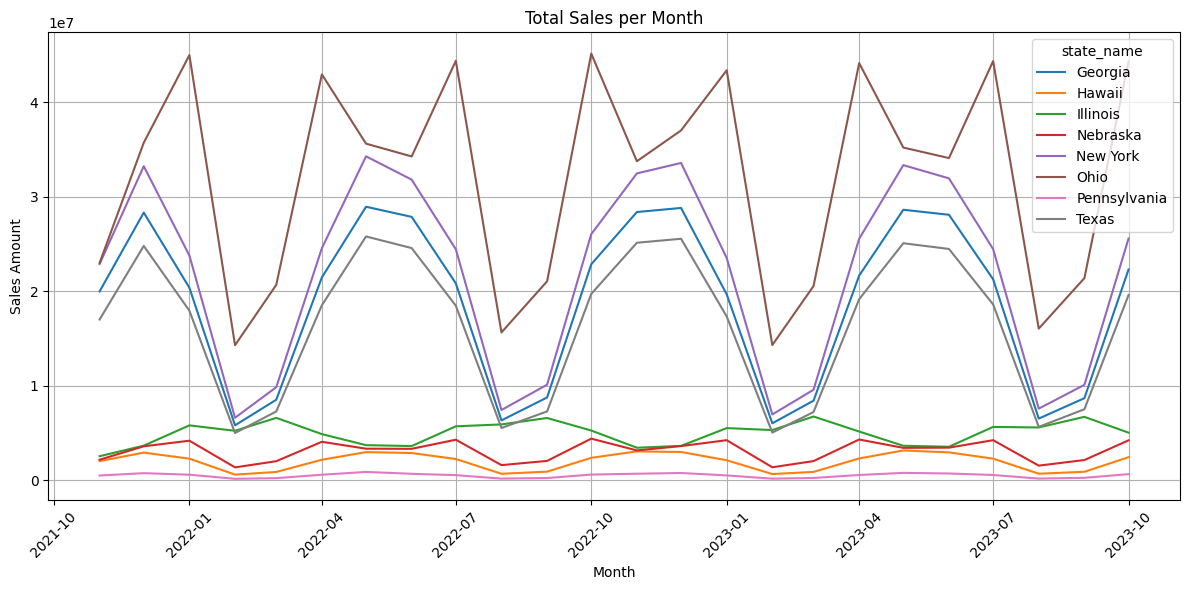

In [89]:
plt.figure(figsize=(12,6))

sns.lineplot(data=df_month_state, x='month', y= 'revenue', hue='state_name')

plt.title("Total Sales per Month")
plt.xlabel("Month")
plt.ylabel("Sales Amount")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

,date,quantity,product_cost,selling_cost,revenue
count,5369952,5.369952e+06,5.369952e+06,5.369952e+06,5.369952e+06
mean,2024-06-09 21:47:43.646620928,1.689094e+02,6.603762e+00,1.406573e+01,1.260368e+03
min,2021-11-10 00:00:00,-1.000000e+00,1.340000e+00,7.710000e+00,-9.750000e+00
25%,2023-04-03 00:00:00,5.300000e+01,4.760000e+00,1.283000e+01,3.857700e+02
50%,2024-08-30 00:00:00,1.390000e+02,7.240000e+00,1.448000e+01,1.008200e+03
75%,2025-11-21 00:00:00,2.650000e+02,8.920000e+00,1.605000e+01,1.933750e+03
max,2025-11-21 00:00:00,5.000000e+02,9.770000e+00,1.864000e+01,4.875000e+03
std,NaN,1.330707e+02,2.568646e+00,2.884132e+00,1.037597e+03


## ML model

In [27]:
df_sales_joined = df_sales.merge(df_regions[["id", 'state_name', 'city']], left_on = 'region_id', right_on = 'id')[['date','quantity','payment_method','state_name','city']]

In [28]:
df_sales_joined.tail()

,date,quantity,payment_method,state_name,city
5369947,2025-11-21,385.0,Cash,Ohio,Youngstown
5369948,2025-11-21,465.0,Credit Card,Ohio,Youngstown
5369949,2025-11-21,478.0,Credit Card,Ohio,Youngstown
5369950,2025-11-21,465.0,Mobile App,Ohio,Youngstown
5369951,2025-11-21,39.0,Mobile App,Ohio,Youngstown


In [29]:
df_sales_joined.head()

,date,quantity,payment_method,state_name,city
0,2021-11-10,54.0,Cash,Georgia,Cartersville
1,2021-11-10,96.0,Cash,Georgia,Cartersville
2,2021-11-10,41.0,Mobile App,Georgia,Cartersville
3,2021-11-10,102.0,Cash,Georgia,Cartersville
4,2021-11-10,62.0,Debit Card,Georgia,Cartersville


In [30]:
# we create a month_name and year column

df_sales_joined['month_name'] = df_sales_joined['date'].dt.month_name()
df_sales_joined['year'] = df_sales_joined['date'].dt.year


In [31]:


# we focus on the sales that do not belong to the current month
df_last_months = df_sales_joined[df_sales_joined["date"]<'2025-11-01']



In [32]:
df_last_months.head()

,date,quantity,payment_method,state_name,city,month_name,year
0,2021-11-10,54.0,Cash,Georgia,Cartersville,November,2021
1,2021-11-10,96.0,Cash,Georgia,Cartersville,November,2021
2,2021-11-10,41.0,Mobile App,Georgia,Cartersville,November,2021
3,2021-11-10,102.0,Cash,Georgia,Cartersville,November,2021
4,2021-11-10,62.0,Debit Card,Georgia,Cartersville,November,2021


In [33]:

month_order = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November', 'December']


In [34]:
def transformer(dataframe):
    df = dataframe.copy()

    # we transform the month_name column into category type
    df = (df.groupby(["year","month_name", "city"])["quantity"].sum()).reset_index()
    
    df['month_name'] = pd.Categorical(df['month_name'], categories=month_order, ordered=True)
    
    df.rename(columns={"quantity":"total_quantity"}, inplace=True)
    df = df.sort_values(["city","year","month_name"], ascending=True).reset_index(drop=True)


    #--we create the main features
    df["last_12m"] = (df.groupby("city")["total_quantity"].rolling(12).sum().reset_index(level=0, drop=True))
    df["last_6m"] = (df.groupby("city")["total_quantity"].rolling(6).sum().reset_index(level=0, drop=True))
    df["last_3m"] = (df.groupby("city")["total_quantity"].rolling(3).sum().reset_index(level=0, drop=True))
    df['lag_1'] = (df.groupby('city')['total_quantity'].shift(1))
    df['lag_2'] = (df.groupby('city')['total_quantity'].shift(2))
    df['lag_3'] = (df.groupby('city')['total_quantity'].shift(3))
    df = df.dropna() #we drop the null values obtained by the last operations


    df['year'] = df['year'].astype(str)
    df['month_name'] = df['month_name'].astype(str)
    df['date'] = pd.to_datetime(df['month_name'] + '-' + df['year'], format="%B-%Y")
    df["quarter"] = df["date"].dt.quarter


    #we convert the columns to the correct data type to train the ML model
    
    df["year"] = df["year"].astype(int)
    df["total_quantity"] = df["total_quantity"].astype(int)
    df["last_12m"] = df["last_12m"].astype(int)
    df["last_6m"] = df["last_6m"].astype(int)
    df["last_3m"] = df["last_3m"].astype(int)
    df["lag_1"] = df["lag_1"].astype(int)
    df["lag_2"] = df["lag_2"].astype(int)
    df["lag_3"] = df["lag_3"].astype(int)


    return df

In [35]:
df_full_sales = transformer(df_sales_joined)

In [36]:
#we obtain the current total quantities for the current month 
df_current_month = df_full_sales[(df_full_sales["month_name"]=="October") & (df_full_sales["year"]==2025)].copy().reset_index(drop=True)

In [37]:
df_last_months = df_full_sales[df_full_sales["date"]<'2025-11-01'].copy()


## Model training

In [54]:
target = "total_quantity"

features = [
    'year', 'city', 'last_12m', 'last_6m', 'last_3m',
    'lag_1', 'lag_2', 'lag_3'
]


In [55]:
train = df_last_months[df_last_months["year"] < 2025]
test  = df_last_months[df_last_months["year"] == 2025]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [61]:
print('Amount of data to train: ', len(train))
print('Amount of data to test: ', len(test))


Amount of data to train:  5292
Amount of data to test:  1960


In [41]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder


numeric_features = ['year', 'last_12m', 'last_6m', 'last_3m',
                    'lag_1', 'lag_2', 'lag_3']

categorical_features = ['city']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # we use an encoder for the categoy
    ]
)


In [42]:
from xgboost import XGBRegressor

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    ))
])


In [43]:
param_distributions = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [3, 4, 5, 6, 8],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__gamma": [0, 1, 5],
    "model__reg_lambda": [0.1, 1, 10],
}


In [44]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'model__colsample_bytree': [0.6, 0.8, ...], 'model__gamma': [0, 1, ...], 'model__learning_rate': [0.01, 0.05, ...], 'model__max_depth': [3, 4, ...], ...}"
,n_iter,30
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [45]:
print("Best parameters:", search.best_params_)

best_model = search.best_estimator_

y_pred = best_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


Best parameters: {'model__subsample': 0.7, 'model__reg_lambda': 0.1, 'model__n_estimators': 500, 'model__max_depth': 6, 'model__learning_rate': 0.1, 'model__gamma': 0, 'model__colsample_bytree': 1.0}
MAE: 1579.2694091796875
RMSE: 3357.9861524431576


To compare those results let's check it with the mean of the total quantity

In [100]:
print('Mean', df_last_months['total_quantity'].mean())

Mean 69405.8305295091


Let's evaluate this result with our model errors

In [105]:
print('MAE %', 1579/69405*100)

MAE % 2.2750522296664504


In [106]:
print('RMSE %' ,3357/69405*100)

RMSE % 4.836827317916577


We can see that the prediction error is tiny compared to the actual volume of our data, which indicate that we got a really good performance

### Export ML model

In [46]:

import joblib
joblib.dump(best_model, '/home/bdcmartinez/Desktop/Projects/Sales-Demand-Forecasting-API/model/model.pkl')

['/home/bdcmartinez/Desktop/Projects/Sales-Demand-Forecasting-API/model/model.pkl']

In [47]:
test = joblib.load('/home/bdcmartinez/Desktop/Projects/Sales-Demand-Forecasting-API/model/model.pkl')


In [51]:

for i, row in df_current_month.iterrows():

    # city name is already readable
    city_name = row["city"]

    # model takes the raw row (pipeline preprocesses automatically)
    prediction = best_model.predict(df_current_month.iloc[i:i+1])[0]

    print(city_name, prediction)


Abington 77519.87
Alamo 81213.1
Albany 72944.7
Albany Park 52598.75
Alice 79896.32
Allen 76814.07
Alpharetta 79801.87
Americus 81098.35
Amherst 77215.445
Arlington 81643.05
Athens 147131.72
Atlanta 80908.766
Auburn 70401.484
Augusta 80145.625
Avon Lake 99308.414
Bay City 69002.34
Bay Shore 76047.086
Bayside 68157.33
Bellaire 79417.695
Bellmore 76569.59
Belton 78012.68
Belvedere Park 75838.17
Berea 94339.234
Boardman 106227.81
Brighton Park 50668.59
Brunswick 172956.03
Calhoun 84723.805
Candler-McAfee 75125.82
Canton 171642.44
Carrollton 85729.71
Cartersville 80153.2
Chamblee 75643.1
Chinatown 72168.43
Cleveland 86712.0
Clifton Park 79719.125
Cohoes 85843.93
Collinwood 97339.47
Columbus 94960.29
Conroe 79169.94
Corona 76211.586
Cuyahoga Falls 100584.8
Cypress Hills 82363.49
Dalton 81778.64
Delaware 88261.58
Depew 81502.836
Detroit-Shoreway 92358.086
Dix Hills 80623.14
Downers Grove 53259.26
Dublin 96737.75
Duluth 84116.18
Dumas 76183.4
Duncanville 72751.94
East Moline 46572.234
East Nor